In [176]:
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import json

def compile_CEFR_setlist()-> list:
    """
    Grouped data structure format:
    groups[group number][column][row]
    group number: 0-5, indexed to [A1, A2, B1, B2, C1, C2]
    column: 'CEFR', 'Text'
    row: zero-indexed
    example: groups[0]['Text'][0]
    pulls first text from A1 group
    """
    with open('./cefr-dataset/data.csv', 'r', encoding="utf-8") as file:
        gb = pd.read_csv(file, index_col=0).applymap(word_tokenize).groupby('CEFR')
        groups = [gb.get_group(group) for group in gb.groups]
    return groups

def build_dataset():
    data = pd.concat(compile_CEFR_setlist())
    data['% High Frequency'] = np.nan
    data['% Full List'] = np.nan

    with open('constraint_lists.json', 'r', encoding="utf-8") as f:
        constraint_lists = json.load(f)
    full_A1_word_list = {word.lower() for unit in constraint_lists['A1 Full List'] for word in constraint_lists['A1 Full List'][unit]}
    high_frequency_A1_word_list = {word.lower() for unit in constraint_lists['A1 High Frequency List'] for word in constraint_lists['A1 High Frequency List'][unit]}

    for i, text in enumerate(data['Text']):
        text = data['Text'][i].copy()
        for word in text:
            if word.isalpha() == False:
                text.remove(word)
        test_text = text
        for word in test_text:
            if word.isalpha() == False:
                text.remove(word)
        text_length = len(test_text)
        for word in text:
            if word.lower() not in full_A1_word_list:
                test_text.remove(word)
        data['% Full List'][i] = len(test_text)/text_length*100
        for word in test_text:
            if word.lower() not in high_frequency_A1_word_list:
                test_text.remove(word)
        data['% High Frequency'][i] = len(test_text)/text_length*100
    return data

data = build_dataset()

C:\Users\William\AppData\Local\Temp\ipykernel_26132\156762594.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['% Full List'][i] = len(test_text)/text_length*100
C:\Users\William\AppData\Local\Temp\ipykernel_26132\156762594.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['% High Frequency'][i] = len(test_text)/text_length*100
C:\Users\William\AppData\Local\Temp\ipykernel_26132\156762594.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [177]:
def get_group_means():
    groups = data.groupby('CEFR')
    high_frequency_means = groups['% High Frequency'].mean()
    full_list_means = groups['% Full List'].mean()
    high_frequency_means_list = high_frequency_means.to_dict()
    full_list_means_list = full_list_means.to_dict()
    print(high_frequency_means_list)
    print(full_list_means_list)
    return high_frequency_means_list, full_list_means_list

{'A1': 61.68118790856647, 'A2': 57.173569350649736, 'B1': 53.978615200492925, 'B2': 48.22632804517786, 'C1': 48.1898508954409, 'C2': 45.32182674507588}
{'A1': 79.36591188843397, 'A2': 75.3880250492941, 'B1': 73.24881685759617, 'B2': 68.18292571049433, 'C1': 68.34014375229461, 'C2': 65.78056300049774}


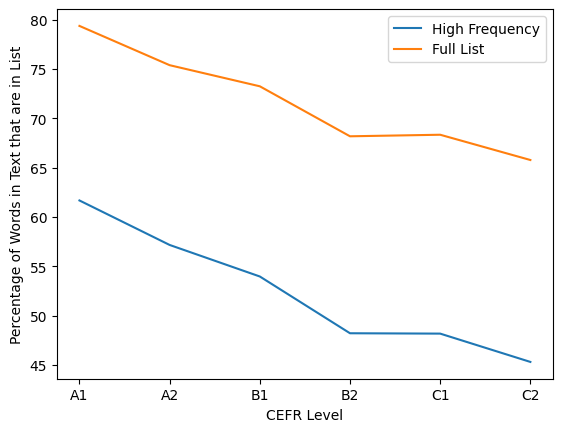

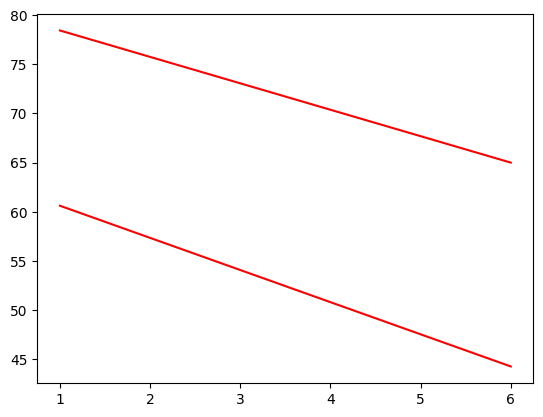

In [178]:
import matplotlib.pyplot as plt
def plot_percentage_curves():
    high_frequency_means_list, full_list_means_list = get_group_means()
    list1 = high_frequency_means_list.items()
    list2 = full_list_means_list.items()
    x1, y1 = zip(*list1)
    x2, y2 = zip(*list2)

    plt.plot(x1, y1)
    plt.plot(x2, y2)
    plt.legend(['High Frequency', 'Full List'])
    plt.xlabel('CEFR Level')
    plt.ylabel('Percentage of Words in Text that are in List')
    plt.show()

    fit1 = np.polyfit(range(1, 7), y1, 1)
    fit2 = np.polyfit(range(1, 7), y2, 1)
    plt.plot(range(1, 7), fit1[0] * range(1, 7) + fit1[1], color='red')
    plt.plot(range(1, 7), fit2[0] * range(1, 7) + fit2[1], color='red')
    plt.show()

plot_percentage_curves()

In [170]:
def word_list_percentages(text):
    for word in text:
        if word.isalpha() == False:
            text.remove(word)
    test_text = text
    for word in test_text:
        if word.isalpha() == False:
            text.remove(word)
    text_length = len(test_text)
    for word in text:
        if word.lower() not in full_A1_word_list:
            test_text.remove(word)
    full_list_percentage = len(test_text)/text_length*100
    for word in test_text:
        if word.lower() not in high_frequency_A1_word_list:
            test_text.remove(word)
    high_frequency_percentage = len(test_text)/text_length*100

    return full_list_percentage, high_frequency_percentage

In [171]:
# def CEFR_level_guesser(high_frequency_percentage, full_list_percentage):
#     hyperparameters = [[-3.2714356668112687, 63.878587858073395],
#                         [-2.6896079850794714, 81.13135899087996]]
#     CEFRs = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
#     m1, b1 = hyperparameters[0]
#     m2, b2 = hyperparameters[1]
#     x1 = round((high_frequency_percentage-b1)/m1)
#     x2 = round((full_list_percentage-b2)/m2)

#     if x1 < 0:
#         level_guess1 = CEFRs[0]
#     elif x1 > 5:
#         level_guess1 = CEFRs[5]
#     else:
#         level_guess1 = CEFRs[x1]

#     if x2 < 0:
#         level_guess2 = CEFRs[0]
#     elif x2 > 5:
#         level_guess2 = CEFRs[5]
#     else:
#         level_guess2 = CEFRs[x2]

#     if level_guess1 == level_guess2:
#         return level_guess1
#     elif x1 > x2:
#         return f'{level_guess2}-{level_guess1}'
#     else:
#         return f'{level_guess1}-{level_guess2}'

In [196]:
print(data['Text'][0])

['ich', 'schon', 'sehr', 'auf', 'Treffen', 'Leider', 'habe', 'ich', 'am', 'noch', 'Termin', 'und', 'kann', 'mittags', 'Kannst', 'Du', 'an', 'Und', 'bitte', 'noch', 'Nur', 'für', 'Und', 'das', 'wir', 'mit', 'und', 'Familien', 'groß', 'draußen', 'Restaurant', 'am', 'könnt', 'ihr', 'bei', 'von', 'Wir', 'habe', 'ich', 'Reise', 'Also', 'wir', 'fahren', 'nach', 'Da', 'gibt', 'Hotel', 'nur', 'noch', 'aber', 'ich', 'das', 'für', 'Nacht', 'Dort', 'Und', 'am', 'Mittwoch', 'fahren', 'wir', 'dann', 'zurück', 'Noch', 'Fragen', 'Du', 'morgen', 'nicht', 'zu', 'am', 'Telefon', 'Ich', 'aber', 'du', 'kannst', 'dann', 'ich', 'sofort']


In [197]:
import cefr
import importlib
importlib.reload(cefr)

sample_text = ['ich', 'schon', 'sehr', 'auf', 'Treffen', 'Leider', 'habe', 'ich', 'am', 'noch', 'Termin', 
               'und', 'kann', 'mittags', 'Kannst', 'Du', 'an', 'Und', 'bitte', 'noch', 'Nur', 'für', 'Und', 
               'das', 'wir', 'mit', 'und', 'Familien', 'groß', 'draußen', 'Restaurant', 'am', 'könnt', 
               'ihr', 'bei', 'von', 'Wir', 'habe', 'ich', 'Reise', 'Also', 'wir', 'fahren', 'nach', 'Da', 
               'gibt', 'Hotel', 'nur', 'noch', 'aber', 'ich', 'das', 'für', 'Nacht', 'Dort', 'Und', 'am', 
               'Mittwoch', 'fahren', 'wir', 'dann', 'zurück', 'Noch', 'Fragen', 'Du', 'morgen', 'nicht', 
               'zu', 'am', 'Telefon', 'Ich', 'aber', 'du', 'kannst', 'dann', 'ich', 'sofort']

level_guess = cefr.CEFR_level_guesser(sample_text)
print(f'The text is at approximately {level_guess} level.')

The text is at approximately A1 level.


In [60]:
test_text = data['Text'][1].copy()
print(test_text)
text_length = len(test_text)
for word in test_text:
    if word.lower() not in high_frequency_A1_word_list:
        test_text.remove(word)
print(test_text)
print(f"Percentage of test text in high frequency A1 list: {round(len(test_text)/text_length*100, 2)}")
for word in test_text:
    if word.lower() not in full_A1_word_list:
        test_text.remove(word)
print(test_text)
print(f"Percentage of test text in full A1 list: {round(len(test_text)/text_length*100, 2)}")

['Achtung', 'an', 'Gleis', 'vier', 'Auf', 'Gleis', 'vier', 'fährt', 'ein', 'Intercity-', 'Express', 'nach', 'Hamburg', 'Hauptbahnhof', 'Planmäßige', 'Abfahrt', 'Uhr', 'Bitte', 'Vorsicht', 'bei', 'der', 'Einfahrt', 'Liebe', 'Fahrgäste', 'Bitte', 'beachten', 'Sie', 'Unser', 'schließt', 'heute', 'bereits', 'um', 'Uhr', 'Warme', 'und', 'kalte', 'Getränke', 'bekommen', 'Sie', 'aber', 'auch', 'später', 'noch', 'an', 'unserem', 'Automaten', 'in', 'der', 'Zugmitte', 'Verehrte', 'Fahrgäste', 'wegen', 'des', 'starken', 'Windes', 'kommt', 'der', 'ICE', 'aus', 'Stuttgart', 'mit', 'Weiterfahrt', 'nach', 'München', 'circa', 'Minuten', 'später', 'als', 'geplant', 'Liebe', 'Kunden', 'die', 'Geschäfte', 'im', 'Bahnhof', 'bieten', 'Ihnen', 'heute', 'eine', 'Sonderaktion', 'Kaufen', 'Sie', 'alle', 'Produkte', 'mit', '%', 'Rabatt', 'Nur', 'heute', 'greifen', 'Sie', 'zu', 'Achtung', 'eine', 'Durchsage', 'Frau', 'Müller', 'bitte', 'kommen', 'Sie', 'zur', 'Information', 'Ihre', 'Tochter', 'wartet', 'hier', '

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("dbmdz/german-gpt2")
model = AutoModelWithLMHead.from_pretrained("dbmdz/german-gpt2")

In [ ]:
import json
from random import randint

with open('constraint_lists.json', 'r', encoding="utf-8") as f:
    constraint_lists = json.load(f)
# Picks a random unit (1-12) list from A1 word list 
unit = randint(1, len(constraint_lists["A1 Full List"]))
constraint_list = constraint_lists["A1 Full List"][f"Unit {unit}"]
# Take a slice as constraint list for generation
index = randint(0, len(constraint_list)-20)
constraint_sample = constraint_list[index:index+20]
force_words_ids = [
    tokenizer(constraint_sample, add_special_tokens=False).input_ids,
]

max_token_limit = 1000

chat_history = ["[INST] <<SYS>> You are a friendly German language partner. Your role is to chat with language learners to help them improve their language skills. Your answers should be brief, friendly and conversational. Please answer in A1-level German. <</SYS>>\n"]

while True:
    # Get user input
    user_input = input("You: ")

    # Add user input to the chat history
    chat_history.append(user_input + "\n")

    # Concatenate and truncate the chat history to fit within the token limit
    combined_history = " ".join(chat_history)
    combined_history += " [/INST]"
    context = combined_history
    print("history so far:", combined_history)
    if len(tokenizer.encode(combined_history)) > max_token_limit:
        # Truncate the chat history to fit within the token limit
        while len(tokenizer.encode(combined_history)) > max_token_limit:
            chat_history.pop(1)

    tokenized_prompt = tokenizer.encode(combined_history, return_tensors="pt")
    # Generate a response based on the chat history
    outputs = model.generate(
        tokenized_prompt,
        force_words_ids=force_words_ids,
        num_beams=10,
        num_return_sequences=1,
        no_repeat_ngram_size=1,
        remove_invalid_values=True,
        max_new_tokens=50,
    )

    # Extract and print the chatbot's response
    bot_response = tokenizer.decode(outputs[0])[len(context):]
    print("Chatbot: ", bot_response)

    # Add the bot's response to the chat history
    chat_history.append(bot_response + "\n")